# GPU-Accelerated Spark Connect - SQL/DF ETL and MLLib on Mortgage Dataset (Spark 4.0+)

Based on the Data and AI Summit 2025 session: [GPU Accelerated Spark Connect](https://www.databricks.com/dataaisummit/session/gpu-accelerated-spark-connect)


Import packages

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, FeatureHasher
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
import csv
import os
import pandas as pd
import time

## Connect to Spark via Spark Connect


In [2]:
# Create GPU-accelerated Spark session using Spark Connect 4.0+
spark = (
  SparkSession.builder
    .remote('sc://spark-connect-server')
    .appName('GPU-Accelerated-ETL-ML-Demo') 
    .getOrCreate()
)
print(f'Spark Connect session id: {spark.session_id}')
print(f'Spark version: {spark.version}')
# workaround for repeated executions
spark.catalog.clearCache()

Spark Connect session id: e7fc28bb-04e9-4997-99a2-7795148f4204
Spark version: 4.0.0


## Smoke Test GPU


In [3]:
df = (
  spark.range(2 ** 35)
    .withColumn('mod10', col('id') % lit(10))
    .groupBy('mod10').agg(count('*'))
    .orderBy('mod10')
)
df.show()
# workaround to get a plan with GpuOverrides applied by disabling adaptive execution
spark.conf.set('spark.sql.adaptive.enabled', False)
df.explain(mode='extended')
spark.conf.set('spark.sql.adaptive.enabled', True)

+-----+----------+
|mod10|  count(1)|
+-----+----------+
|    0|3435973837|
|    1|3435973837|
|    2|3435973837|
|    3|3435973837|
|    4|3435973837|
|    5|3435973837|
|    6|3435973837|
|    7|3435973837|
|    8|3435973836|
|    9|3435973836|
+-----+----------+

== Parsed Logical Plan ==
'Sort ['mod10 ASC NULLS FIRST], true
+- 'Aggregate ['mod10], ['mod10, unresolvedalias('count(*))]
   +- 'Project [unresolvedstarwithcolumns(mod10, '`%`('id, 10), Some(List({})))]
      +- Range (0, 34359738368, step=1, splits=Some(16))

== Analyzed Logical Plan ==
mod10: bigint, count(1): bigint
Sort [mod10#92421L ASC NULLS FIRST], true
+- Aggregate [mod10#92421L], [mod10#92421L, count(1) AS count(1)#92423L]
   +- Project [id#92386L, (id#92386L % cast(10 as bigint)) AS mod10#92421L]
      +- Range (0, 34359738368, step=1, splits=Some(16))

== Optimized Logical Plan ==
Sort [mod10#92421L ASC NULLS FIRST], true
+- Aggregate [mod10#92421L], [mod10#92421L, count(1) AS count(1)#92423L]
   +- Project [(i

##  Should GPU Be Used from the next cell on?


In [4]:
accelerate_on_gpu = True

### ETL on GPU?

In [5]:
spark.conf.set('spark.rapids.sql.enabled', accelerate_on_gpu)  

### ML on GPU?

In [6]:
if accelerate_on_gpu:
  spark.conf.set('spark.connect.ml.backend.classes', 'com.nvidia.rapids.ml.Plugin')
else:
  spark.conf.unset('spark.connect.ml.backend.classes')

## Normalize references to the same bank 

In [7]:
os.getcwd()

'/home/jovyan'

In [8]:
with open('/home/jovyan/work/name_mapping.csv', 'r') as name_mapping_file:
  nm_reader = csv.reader(name_mapping_file,)
  name_mapping = [r for r in nm_reader]
name_mapping_df = spark.createDataFrame(name_mapping, ['from_seller_name', 'to_seller_name'])

(
  name_mapping_df
    .where(col('to_seller_name') == 'Wells Fargo' )
    .show(truncate=False)
)

+------------------------------------------------------+--------------+
|from_seller_name                                      |to_seller_name|
+------------------------------------------------------+--------------+
|WELLS FARGO CREDIT RISK TRANSFER SECURITIES TRUST 2015|Wells Fargo   |
|WELLS FARGO BANK,  NA                                 |Wells Fargo   |
|WELLS FARGO BANK, N.A.                                |Wells Fargo   |
|WELLS FARGO BANK, NA                                  |Wells Fargo   |
+------------------------------------------------------+--------------+



In [9]:
# String columns
cate_col_names = [
  'orig_channel',
  'first_home_buyer',
  'loan_purpose',
  'property_type',
  'occupancy_status',
  'property_state',
  'product_type',
  'relocation_mortgage_indicator',
  'seller_name',
  'mod_flag'
]
# Numeric columns
label_col_name = 'delinquency_12'
numeric_col_names = [
  'orig_interest_rate',
  'orig_upb',
  'orig_loan_term',
  'orig_ltv',
  'orig_cltv',
  'num_borrowers',
  'dti',
  'borrower_credit_score',
  'num_units',
  'zip',
  'mortgage_insurance_percent',
  'current_loan_delinquency_status',
  'current_actual_upb',
  'interest_rate',
  'loan_age',
  'msa',
  'non_interest_bearing_upb',
  label_col_name
]
all_col_names = cate_col_names + numeric_col_names

## Define ETL Process

### Functions to read raw columns

In [10]:
def read_raw_csv(spark, path):
  def _get_quarter_from_csv_file_name():
    return substring_index(substring_index(input_file_name(), '.', 1), '/', -1)

  with open('/home/jovyan/work/csv_raw_schema.ddl', 'r') as f:
    _csv_raw_schema_str = f.read()
  
  return (
    spark.read
    .format('csv') 
    .option('nullValue', '') 
    .option('header', False) 
    .option('delimiter', '|') 
    .schema(_csv_raw_schema_str) 
    .load(path) 
    .withColumn('quarter', _get_quarter_from_csv_file_name())
  )

def extract_perf_columns(rawDf):
  perfDf = rawDf.select(
    col('loan_id'),
    date_format(to_date(col('monthly_reporting_period'),'MMyyyy'), 'MM/dd/yyyy').alias('monthly_reporting_period'),
    upper(col('servicer')).alias('servicer'),
    col('interest_rate'),
    col('current_actual_upb'),
    col('loan_age'),
    col('remaining_months_to_legal_maturity'),
    col('adj_remaining_months_to_maturity'),
    date_format(to_date(col('maturity_date'),'MMyyyy'), 'MM/yyyy').alias('maturity_date'),
    col('msa'),
    col('current_loan_delinquency_status'),
    col('mod_flag'),
    col('zero_balance_code'),
    date_format(to_date(col('zero_balance_effective_date'),'MMyyyy'), 'MM/yyyy').alias('zero_balance_effective_date'),
    date_format(to_date(col('last_paid_installment_date'),'MMyyyy'), 'MM/dd/yyyy').alias('last_paid_installment_date'),
    date_format(to_date(col('foreclosed_after'),'MMyyyy'), 'MM/dd/yyyy').alias('foreclosed_after'),
    date_format(to_date(col('disposition_date'),'MMyyyy'), 'MM/dd/yyyy').alias('disposition_date'),
    col('foreclosure_costs'),
    col('prop_preservation_and_repair_costs'),
    col('asset_recovery_costs'),
    col('misc_holding_expenses'),
    col('holding_taxes'),
    col('net_sale_proceeds'),
    col('credit_enhancement_proceeds'),
    col('repurchase_make_whole_proceeds'),
    col('other_foreclosure_proceeds'),
    col('non_interest_bearing_upb'),
    col('principal_forgiveness_upb'),
    col('repurchase_make_whole_proceeds_flag'),
    col('foreclosure_principal_write_off_amount'),
    col('servicing_activity_indicator'),
    col('quarter')
  )
  return perfDf.select('*').filter('current_actual_upb != 0.0')

def extract_acq_columns(rawDf):
  acqDf = rawDf.select(
    col('loan_id'),
    col('orig_channel'),
    upper(col('seller_name')).alias('seller_name'),
    col('orig_interest_rate'),
    col('orig_upb'),
    col('orig_loan_term'),
    date_format(to_date(col('orig_date'),'MMyyyy'), 'MM/yyyy').alias('orig_date'),
    date_format(to_date(col('first_pay_date'),'MMyyyy'), 'MM/yyyy').alias('first_pay_date'),
    col('orig_ltv'),
    col('orig_cltv'),
    col('num_borrowers'),
    col('dti'),
    col('borrower_credit_score'),
    col('first_home_buyer'),
    col('loan_purpose'),
    col('property_type'),
    col('num_units'),
    col('occupancy_status'),
    col('property_state'),
    col('zip'),
    col('mortgage_insurance_percent'),
    col('product_type'),
    col('coborrow_credit_score'),
    col('mortgage_insurance_type'),
    col('relocation_mortgage_indicator'),
    dense_rank().over(Window.partitionBy('loan_id').orderBy(to_date(col('monthly_reporting_period'),'MMyyyy'))).alias('rank'),
    col('quarter')
  )

  return acqDf.select('*').filter(col('rank')==1)

### Define function to parse date in Performance data 

In [11]:
def _parse_dates(perf):
  return (
    perf.withColumn('monthly_reporting_period', to_date(col('monthly_reporting_period'), 'MM/dd/yyyy')) 
      .withColumn('monthly_reporting_period_month', month(col('monthly_reporting_period'))) 
      .withColumn('monthly_reporting_period_year', year(col('monthly_reporting_period'))) 
      .withColumn('monthly_reporting_period_day', dayofmonth(col('monthly_reporting_period'))) 
      .withColumn('last_paid_installment_date', to_date(col('last_paid_installment_date'), 'MM/dd/yyyy')) 
      .withColumn('foreclosed_after', to_date(col('foreclosed_after'), 'MM/dd/yyyy')) 
      .withColumn('disposition_date', to_date(col('disposition_date'), 'MM/dd/yyyy')) 
      .withColumn('maturity_date', to_date(col('maturity_date'), 'MM/yyyy')) 
  )

### Define function to create deliquency data frame from Performance data.  

The computed `delinquency_12` column denotes whether a loan will become delinquent by 3, 6, or 9 months, 
or not delinquent, within the next 12 month period.   

It will be the target label for ML multi-class prediction.

In [12]:
def _create_perf_deliquency(spark, perf):
  aggDF = (
    perf
      .select(
        col('quarter'),
        col('loan_id'),
        col('current_loan_delinquency_status'),
        when(col('current_loan_delinquency_status') >= 1, col('monthly_reporting_period')).alias('delinquency_30'),
        when(col('current_loan_delinquency_status') >= 3, col('monthly_reporting_period')).alias('delinquency_90'),
        when(col('current_loan_delinquency_status') >= 6, col('monthly_reporting_period')).alias('delinquency_180')
      ).groupBy('quarter', 'loan_id')
       .agg(
         max('current_loan_delinquency_status').alias('delinquency_12'),
         min('delinquency_30').alias('delinquency_30'),
         min('delinquency_90').alias('delinquency_90'),
         min('delinquency_180').alias('delinquency_180')
       ).select(
         col('quarter'),
         col('loan_id'),
         (col('delinquency_12') >= 1).alias('ever_30'),
         (col('delinquency_12') >= 3).alias('ever_90'),
         (col('delinquency_12') >= 6).alias('ever_180'),
         col('delinquency_30'),
         col('delinquency_90'),
         col('delinquency_180')
       )
  )
  #aggDF.printSchema()
  joinedDf = (
    perf
      .withColumnRenamed('monthly_reporting_period', 'timestamp')
      .withColumnRenamed('monthly_reporting_period_month', 'timestamp_month') 
      .withColumnRenamed('monthly_reporting_period_year', 'timestamp_year') 
      .withColumnRenamed('current_loan_delinquency_status', 'delinquency_12') 
      .withColumnRenamed('current_actual_upb', 'upb_12') 
      .select('quarter', 'loan_id', 'timestamp', 'delinquency_12', 'upb_12', 'timestamp_month', 'timestamp_year') 
      .join(aggDF, ['loan_id', 'quarter'], 'left_outer')
  )
  # calculate the 12 month delinquency and upb values
  months = 12
  monthArray = [lit(x) for x in range(0, 12)]
  
  testDf = ( 
    joinedDf
      .withColumn('month_y', explode(array(monthArray)))
      .select(
        col('quarter'),
        floor(((col('timestamp_year') * 12 + col('timestamp_month')) - 24000) / months).alias('josh_mody'),
        floor(((col('timestamp_year') * 12 + col('timestamp_month')) - 24000 - col('month_y')) / months).alias('josh_mody_n'),
        col('ever_30'),
        col('ever_90'),
        col('ever_180'),
        col('delinquency_30'),
        col('delinquency_90'),
        col('delinquency_180'),
        col('loan_id'),
        col('month_y'),
        col('delinquency_12'),
        col('upb_12')
      ).groupBy('quarter', 'loan_id', 'josh_mody_n', 'ever_30', 'ever_90', 'ever_180', 'delinquency_30', 'delinquency_90', 'delinquency_180', 'month_y')
    .agg(max('delinquency_12').alias('delinquency_12'), min('upb_12').alias('upb_12')) 
    .withColumn('timestamp_year', floor((lit(24000) + (col('josh_mody_n') * lit(months)) + (col('month_y') - 1)) / lit(12))) 
    .selectExpr('*', f'pmod(24000 + (josh_mody_n * {months}) + month_y, 12) as timestamp_month_tmp') 
    .withColumn('timestamp_month', when(col('timestamp_month_tmp') == lit(0), lit(12)).otherwise(col('timestamp_month_tmp'))) 
    .withColumn('delinquency_12', ((col('delinquency_12') > 9).cast('int') + (col('delinquency_12') > 6).cast('int') + (col('delinquency_12') > 3).cast('int') + (col('upb_12') == 0).cast('int')).alias('delinquency_12')) 
    .drop('timestamp_month_tmp', 'josh_mody_n', 'month_y')
  )

  return (
    perf
      .withColumnRenamed('monthly_reporting_period_month', 'timestamp_month')
      .withColumnRenamed('monthly_reporting_period_year', 'timestamp_year')
      .join(testDf, ['quarter', 'loan_id', 'timestamp_year', 'timestamp_month'], 'left')
      .drop('timestamp_year', 'timestamp_month')
  )

### Define function to create acquisition data frame from Acquisition data

In [13]:
def _create_acquisition(spark, acq):
  return (
    acq.join(name_mapping_df, col('seller_name') == col('from_seller_name'), 'left')
      .drop('from_seller_name') 
      .withColumn('old_name', col('seller_name')) 
      .withColumn('seller_name', coalesce(col('to_seller_name'), col('seller_name'))) 
      .drop('to_seller_name') 
      .withColumn('orig_date', to_date(col('orig_date'), 'MM/yyyy')) 
      .withColumn('first_pay_date', to_date(col('first_pay_date'), 'MM/yyyy')) 
  )

### Define Casting Process


This part is casting String column to Numeric one. 
Example:
```
col_1
 "a"
 "b"
 "c"
 "a"
# After String ====> Numeric
col_1
 0
 1
 2
 0
```  

### Define function to get column dictionary

Example

```
col1 = [row(data="a",id=0), row(data="b",id=1)]
```

In [14]:
def _gen_dictionary(etl_df, col_names):
  cnt_table = (
    etl_df.select(posexplode(array([col(i) for i in col_names])))
      .withColumnRenamed('pos', 'column_id')
      .withColumnRenamed('col', 'data')
      .filter('data is not null')
      .groupBy('column_id', 'data')
      .count()
  )
  windowed = Window.partitionBy('column_id').orderBy(desc('count'))
  return cnt_table.withColumn('id', row_number().over(windowed)).drop('count')

### Define function to convert string columns to numeric



In [15]:
def _cast_string_columns_to_numeric(spark, input_df):
  cached_dict_df = _gen_dictionary(input_df, cate_col_names).cache()
  output_df = input_df
  #  Generate the final table with all columns being numeric.
  for col_pos, col_name in enumerate(cate_col_names):
    col_dict_df = (
      cached_dict_df.filter(col('column_id') == col_pos)
        .drop('column_id')
        .withColumnRenamed('data', col_name)
    )
    output_df = (
      output_df.join(broadcast(col_dict_df), col_name, 'left')
        .drop(col_name)
        .withColumnRenamed('id', col_name)
    )
  return output_df     

### Define Main Function

In this function:
1. Parse date in Performance data by calling _parse_dates (parsed_perf)
2. Create deliqency dataframe(perf_deliqency) form Performance data by calling _create_perf_deliquency
3. Create cleaned acquisition dataframe(cleaned_acq) from Acquisition data by calling _create_acquisition
4. Join deliqency dataframe(perf_deliqency) and cleaned acquisition dataframe(cleaned_acq), get clean_df
5. Cast String column to Numeric in clean_df by calling _cast_string_columns_to_numeric, get casted_clean_df
6. Return casted_clean_df as final result

In [16]:
def run_mortgage(spark, perf, acq):
  parsed_perf = _parse_dates(perf)
  perf_deliqency = _create_perf_deliquency(spark, parsed_perf)
  cleaned_acq = _create_acquisition(spark, acq)
  clean_df = perf_deliqency.join(cleaned_acq, ['loan_id', 'quarter'], 'inner').drop('quarter')
  casted_clean_df = (
    _cast_string_columns_to_numeric(spark, clean_df)
      .select(all_col_names)
      .withColumn(label_col_name, when(col(label_col_name) > 0, col(label_col_name)).otherwise(0))
      .fillna(float(0))
  )
  return casted_clean_df

### Run ETL Pipeline

#### Read Raw Data and Run ETL Process, Save the Result

##### Convert CSV to Parquet

In [17]:
# comment out if already converted
mortgage_csv = read_raw_csv(spark, '/data/mortgage.input.csv')
mortgage_csv.write.parquet('/opt/spark/work-dir/mortgage.parquet', mode='overwrite')

##### ETL from Parquet Data

In [18]:
mortgage_pq = spark.read.parquet('/opt/spark/work-dir/mortgage.parquet')
acq = extract_acq_columns(mortgage_pq)
perf = extract_perf_columns(mortgage_pq)
# run main function to process data
preprocessed = run_mortgage(spark, perf, acq)
# save processed data
start = time.time()
preprocessed.write.parquet('/opt/spark/work-dir/mortgage-preprocessed.parquet', mode='overwrite')
end = time.time()
etl_dur = end - start
print(f'ETL takes {etl_dur}')

ETL takes 24.471089839935303


### Run ML

#### The ML modeling phase of the example uses the `spark.ml` Pipeline API to carry out the following steps on a random subsample of the ETL output:
  - use `spark.ml FeatureHasher` to map the int type columns in the ETL output to a 2^15 dimensional sparse feature vector with a non-zero entry in each location corresponding to hash value of each input column value + column name.
  - use `spark.ml VectorAssembler` to combine the output of `FeatureHasher` with the original float type columns into a single `VectorUDT` type feature vector
  - train a model using `LogisticRegression` to predict the multi-class (4 class values) label "delinquency_12".

In [19]:
etlDf = spark.read.parquet('/opt/spark/work-dir/mortgage-preprocessed.parquet')
etlDf.describe().show(vertical=True, truncate=False)

-RECORD 0------------------------------------------------
 summary                         | count                 
 orig_channel                    | 3537069               
 first_home_buyer                | 3537069               
 loan_purpose                    | 3537069               
 property_type                   | 3537069               
 occupancy_status                | 3537069               
 property_state                  | 3537069               
 product_type                    | 3537069               
 relocation_mortgage_indicator   | 3537069               
 seller_name                     | 3537069               
 mod_flag                        | 3537069               
 orig_interest_rate              | 3537069               
 orig_upb                        | 3537069               
 orig_loan_term                  | 3537069               
 orig_ltv                        | 3537069               
 orig_cltv                       | 3537069               
 num_borrowers

In [20]:
etlDf = etlDf.sample(fraction=0.1, seed=1234)
etlDf.describe().show(vertical=True, truncate=False)

-RECORD 0-----------------------------------------------
 summary                         | count                
 orig_channel                    | 354327               
 first_home_buyer                | 354327               
 loan_purpose                    | 354327               
 property_type                   | 354327               
 occupancy_status                | 354327               
 property_state                  | 354327               
 product_type                    | 354327               
 relocation_mortgage_indicator   | 354327               
 seller_name                     | 354327               
 mod_flag                        | 354327               
 orig_interest_rate              | 354327               
 orig_upb                        | 354327               
 orig_loan_term                  | 354327               
 orig_ltv                        | 354327               
 orig_cltv                       | 354327               
 num_borrowers                 

In [21]:
etlDf = etlDf.withColumn('loc',(etlDf.msa*1000+etlDf.zip).cast('int')).drop('zip' ,'msa')

In [22]:

label_col_name = 'delinquency_12'
schema = etlDf.schema
raw_features = [ x for x in schema.fields if x.name != label_col_name ]

In [23]:


categorical_cols = [f.name for f in raw_features if f.dataType == IntegerType()]
numerical_cols = [f.name for f in raw_features if f.name not in categorical_cols]
hasher = FeatureHasher(inputCols=categorical_cols, outputCol='hashed_categorical', 
                       categoricalCols=categorical_cols, numFeatures=(1 << 15))
va = VectorAssembler().setInputCols(numerical_cols + [hasher.getOutputCol()]).setOutputCol('features')

In [24]:
logistic =  ( 
  LogisticRegression()
    .setMaxIter(200)
    .setRegParam(0.00002)
    .setElasticNetParam(0.1)
    .setTol(1.0e-12)
    .setFeaturesCol('features')
    .setLabelCol(label_col_name)
)

In [25]:
[df_train, df_test] = etlDf.randomSplit([0.8, 0.2], seed=1234)
pipeline = Pipeline().setStages([hasher, va, logistic])

In [26]:
start = time.time()
# gpu lr, gpu etl, gpu transform, 200 iters, double precision, elasticnet=0.1, featurehasher, 0.1 sample, multiclass, float64
pipeline_model = pipeline.fit(df_train)

In [27]:
predictions = pipeline_model.transform(df_test)
predictions.sample(0.1).show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 orig_channel                    | 1                                                                                                                                                                                                                               
 first_home_buyer                | 1                                                                                                                                                                                                                               
 loan_purpose                    | 1                                                                                                                                                                                        

In [28]:
evaluator = MulticlassClassificationEvaluator().setMetricName('logLoss').setLabelCol(label_col_name)
eval_res = evaluator.evaluate(predictions)
end = time.time()
print(f'Evaluation result: {eval_res}')

Evaluation result: 0.004466397045524066


In [29]:
ml_dur = end - start
print(f'ML takes {ml_dur}')

ML takes 13.333730459213257


# Save current run times  

In [30]:
run_times = pd.Series({'etl' : etl_dur, 'ml' : ml_dur})
run_times.to_csv('/opt/spark/work-dir/gpu_times.csv' if accelerate_on_gpu else '/opt/spark/work-dir/cpu_times.csv', index=True, header=False)

# Visualize acceleration

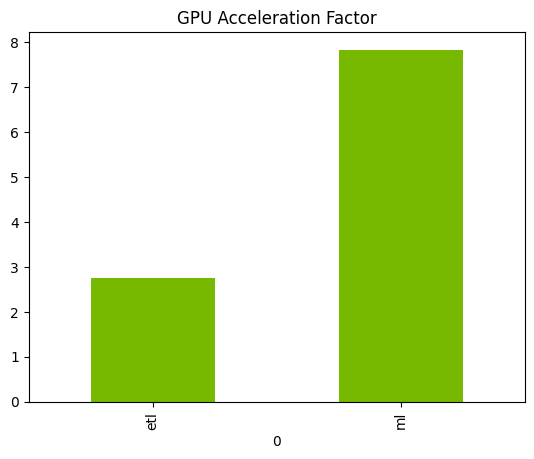

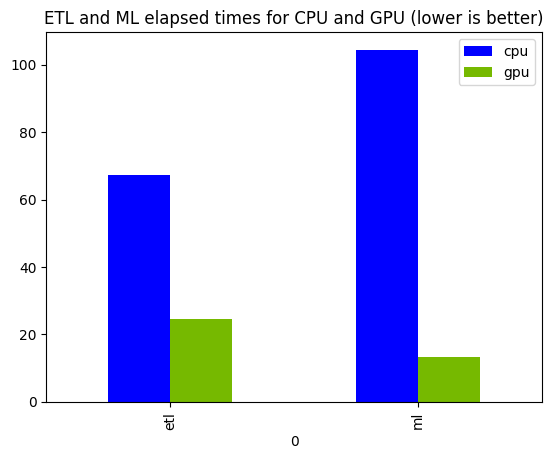

In [31]:
if os.path.exists('/opt/spark/work-dir/cpu_times.csv') and os.path.exists('/opt/spark/work-dir/gpu_times.csv'):
  cpu_times = pd.read_csv('/opt/spark/work-dir/cpu_times.csv', header=None, index_col=0)
  gpu_times = pd.read_csv('/opt/spark/work-dir/gpu_times.csv', header=None, index_col=0)
  gpu_speedup = cpu_times / gpu_times
  gpu_speedup.plot(kind='bar', 
    title='GPU Acceleration Factor', 
    color='#76B900', 
    legend=False)
  cpu_times = cpu_times[1].rename('cpu')
  gpu_times = gpu_times[1].rename('gpu')
  times = pd.DataFrame([cpu_times, gpu_times]).transpose()
  times.plot(kind='bar', 
    title = 'ETL and ML elapsed times for CPU and GPU (lower is better)', 
    color=['blue', '#76B900'])